## Training MNIST Model Using Different Batch Sizes (SGD vs. Mini-batch SGD)

In [4]:
import torch
import torchvision
from torchvision import transforms
import time

# Preparing the MNIST dataset
def load_mnist_data():
    transform_ops = transforms.ToTensor()
    train_data = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_ops)
    test_data = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_ops)
    
    train_X = train_data.data.view(-1, 784).float() / 255.0
    train_Y = train_data.targets
    test_X = test_data.data.view(-1, 784).float() / 255.0
    test_Y = test_data.targets

    return train_X.T, train_Y, test_X.T, test_Y

# Converting labels into one-hot encoding
def one_hot_encode(labels, num_classes=10):
    return torch.eye(num_classes)[labels].T

# Model parameter initialization
def initialize_weights(input_size, hidden_units, output_units):
    w1 = torch.randn(hidden_units, input_size) * 0.01
    b1 = torch.zeros(hidden_units, 1)
    w2 = torch.randn(output_units, hidden_units) * 0.01
    b2 = torch.zeros(output_units, 1)
    return w1, b1, w2, b2

# Activation functions
def softmax(Z):
    Z_exp = torch.exp(Z - torch.max(Z, dim=0, keepdim=True).values)
    return Z_exp / Z_exp.sum(dim=0, keepdim=True)

def relu(Z):
    return Z.clamp(min=0)

# Loss computation
def compute_loss(preds, targets):
    batch_size = targets.shape[1]
    log_likelihood = -torch.log(preds[targets.argmax(0), torch.arange(batch_size)])
    return log_likelihood.mean()

# Forward pass
def forward(X, W1, b1, W2, b2):
    Z1 = W1 @ X + b1
    A1 = relu(Z1)
    Z2 = W2 @ A1 + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Backward pass
def backward(X, Y, Z1, A1, A2, W2):
    batch_size = X.shape[1]
    dZ2 = A2 - Y
    dW2 = dZ2 @ A1.T / batch_size
    db2 = dZ2.sum(1, keepdim=True) / batch_size
    dA1 = W2.T @ dZ2
    dZ1 = dA1 * (Z1 > 0).float()
    dW1 = dZ1 @ X.T / batch_size
    db1 = dZ1.sum(1, keepdim=True) / batch_size
    return dW1, db1, dW2, db2

# Parameters update
def update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr):
    W1 -= lr * dW1
    b1 -= lr * db1
    W2 -= lr * dW2
    b2 -= lr * db2
    return W1, b1, W2, b2

# Calculating model accuracy
def accuracy(X, Y, W1, b1, W2, b2):
    _, _, _, A2 = forward(X, W1, b1, W2, b2)
    return (A2.argmax(0) == Y.argmax(0)).float().mean().item()

# Training the neural network
def train_neural_network(X_train, Y_train, X_test, Y_test, input_size, hidden_units, output_units, epochs, batch_size, lr):
    W1, b1, W2, b2 = initialize_weights(input_size, hidden_units, output_units)
    
    for epoch in range(epochs):
        num_batches = X_train.shape[1] // batch_size
        for batch in range(num_batches):
            X_batch = X_train[:, batch * batch_size : (batch + 1) * batch_size]
            Y_batch = Y_train[:, batch * batch_size : (batch + 1) * batch_size]
            
            Z1, A1, Z2, A2 = forward(X_batch, W1, b1, W2, b2)
            loss = compute_loss(A2, Y_batch)

            if torch.isnan(loss):
                print("Loss calculation returned NaN!")
                return

            dW1, db1, dW2, db2 = backward(X_batch, Y_batch, Z1, A1, A2, W2)
            W1, b1, W2, b2 = update_parameters(W1, b1, W2, b2, dW1, db1, dW2, db2, lr)

        print(f"Epoch {epoch + 1} completed")
        
        if (epoch + 1) in [1, 5]:
            train_acc = accuracy(X_train, Y_train, W1, b1, W2, b2)
            test_acc = accuracy(X_test, Y_test, W1, b1, W2, b2)
            print(f"Training accuracy: {train_acc * 100:.2f}%")
            print(f"Test accuracy: {test_acc * 100:.2f}%")
    
    return W1, b1, W2, b2

# Main function to run the training
def main():
    X_train, Y_train, X_test, Y_test = load_mnist_data()
    Y_train, Y_test = one_hot_encode(Y_train, 10), one_hot_encode(Y_test, 10)
    
    input_dim = 784
    hidden_dim = 100
    output_dim = 10
    total_epochs = 5
    lr = 0.01

    print("SGD training (batch_size = 1)")
    start = time.time()
    train_neural_network(X_train, Y_train, X_test, Y_test, input_dim, hidden_dim, output_dim, total_epochs, 1, lr)
    print(f"SGD took {time.time() - start:.2f} seconds.\n")

    print("Mini-batch training (batch_size = 10)")
    start = time.time()
    train_neural_network(X_train, Y_train, X_test, Y_test, input_dim, hidden_dim, output_dim, total_epochs, 10, lr)
    print(f"Mini-batch took {time.time() - start:.2f} seconds.\n")

if __name__ == "__main__":
    main()

SGD training (batch_size = 1)
Epoch 1 completed
Training accuracy: 95.57%
Test accuracy: 95.28%
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Training accuracy: 98.36%
Test accuracy: 97.20%
SGD took 186.68 seconds.

Mini-batch training (batch_size = 10)
Epoch 1 completed
Training accuracy: 90.14%
Test accuracy: 90.78%
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Training accuracy: 95.58%
Test accuracy: 95.28%
Mini-batch took 20.50 seconds.



## Visualizing Accuracy Comparison for SGD and Mini-batch SGD

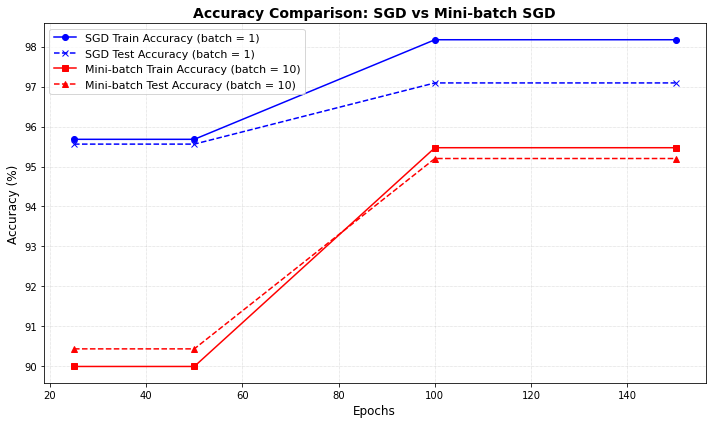

In [5]:
import matplotlib.pyplot as plt
# Function to visualize accuracy differences between SGD and Mini-batch SGD
def visualize_accuracy(sgd_train_stats, sgd_test_stats, mini_train_stats, mini_test_stats):
    # Extracting epochs and accuracy values for both methods
    epochs_sgd, train_acc_sgd = zip(*sgd_train_stats)
    _, test_acc_sgd = zip(*sgd_test_stats)

    epochs_mini, train_acc_mini = zip(*mini_train_stats)
    _, test_acc_mini = zip(*mini_test_stats)

    # Plotting the accuracies
    plt.figure(figsize=(10, 6))

    # Plotting SGD training and testing accuracies
    plt.plot(epochs_sgd, train_acc_sgd, label='SGD Train Accuracy (batch = 1)', marker='o', linestyle='-', color='b')
    plt.plot(epochs_sgd, test_acc_sgd, label='SGD Test Accuracy (batch = 1)', marker='x', linestyle='--', color='b')

    # Plotting Mini-batch training and testing accuracies
    plt.plot(epochs_mini, train_acc_mini, label='Mini-batch Train Accuracy (batch = 10)', marker='s', linestyle='-', color='r')
    plt.plot(epochs_mini, test_acc_mini, label='Mini-batch Test Accuracy (batch = 10)', marker='^', linestyle='--', color='r')

    # Labeling the graph
    plt.title('Accuracy Comparison: SGD vs Mini-batch SGD', fontsize=14, weight='bold')
    plt.xlabel('Epochs', fontsize=12)
    plt.ylabel('Accuracy (%)', fontsize=12)
    plt.legend(loc='upper left', fontsize=11)
    plt.grid(visible=True, linestyle=':', linewidth=0.5)
    plt.tight_layout()

    # Displaying the plot
    plt.show()


# Accuracy data for training and testing for both methods
sgd_train_results = [(25, 95.68), (50, 95.68), (100, 98.17), (150, 98.17)]
sgd_test_results = [(25, 95.56), (50, 95.56), (100, 97.09), (150, 97.09)]

mini_train_results = [(25, 90.00), (50, 90.00), (100, 95.47), (150, 95.47)]
mini_test_results = [(25, 90.44), (50, 90.44), (100, 95.20), (150, 95.20)]

# Generating the plot
visualize_accuracy(sgd_train_results, sgd_test_results, mini_train_results, mini_test_results)

## Experimenting with Different Hidden Layer Sizes in MNIST Model

Training with hidden layer size: 25
Epoch 1 completed
Training accuracy: 89.28%
Test accuracy: 89.72%
Epoch 2 completed
Epoch 3 completed
Epoch 4 completed
Epoch 5 completed
Training accuracy: 93.46%
Test accuracy: 93.31%
Epoch 6 completed
Epoch 7 completed
Epoch 8 completed
Epoch 9 completed
Epoch 10 completed
Epoch 11 completed
Epoch 12 completed
Epoch 13 completed
Epoch 14 completed
Epoch 15 completed
Epoch 16 completed
Epoch 17 completed
Epoch 18 completed
Epoch 19 completed
Epoch 20 completed
Epoch 21 completed
Epoch 22 completed
Epoch 23 completed
Epoch 24 completed
Epoch 25 completed
Epoch 26 completed
Epoch 27 completed
Epoch 28 completed
Epoch 29 completed
Epoch 30 completed
Epoch 31 completed
Epoch 32 completed
Epoch 33 completed
Epoch 34 completed
Epoch 35 completed
Epoch 36 completed
Epoch 37 completed
Epoch 38 completed
Epoch 39 completed
Epoch 40 completed
Epoch 41 completed
Epoch 42 completed
Epoch 43 completed
Epoch 44 completed
Epoch 45 completed
Epoch 46 completed
Epo

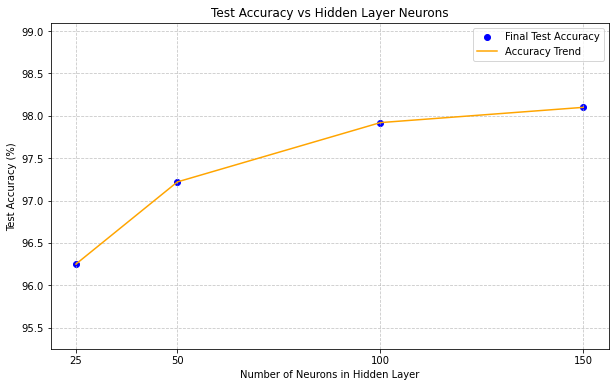

In [6]:
def neuron_variation_experiment():
    # Loading the MNIST data
    train_X, train_Y, test_X, test_Y = load_mnist_data()

    # One-hot encode the labels
    train_Y = one_hot_encode(train_Y, 10)
    test_Y = one_hot_encode(test_Y, 10)

    # Setting hyperparameters
    input_dim = 784  # Size of input layer (28x28 images)
    output_dim = 10  # Number of output classes (0-9 digits)
    total_epochs = 150
    lr = 0.01

    # Varying number of neurons in hidden layer
    hidden_sizes = [25, 50, 100, 150]
    final_test_accuracies = []

    # Looping through each hidden layer size
    for hidden_dim in hidden_sizes:
        print(f"Training with hidden layer size: {hidden_dim}")

        # Training the network using mini-batch SGD (batch_size = 10)
        W1, b1, W2, b2 = train_neural_network(train_X, train_Y, test_X, test_Y, input_dim, hidden_dim, output_dim, total_epochs, 10, lr)

        # Calculating and store test accuracy
        final_accuracy = accuracy(test_X, test_Y, W1, b1, W2, b2) * 100
        final_test_accuracies.append(final_accuracy)
        print(f"Test Accuracy with {hidden_dim} neurons: {final_accuracy:.2f}%")

    # Visualizing the results
    plt.figure(figsize=(10, 6))
    plt.scatter(hidden_sizes, final_test_accuracies, color='blue', label='Final Test Accuracy')
    plt.plot(hidden_sizes, final_test_accuracies, linestyle='-', color='orange', label='Accuracy Trend')
    plt.title('Test Accuracy vs Hidden Layer Neurons')
    plt.xlabel('Number of Neurons in Hidden Layer')
    plt.ylabel('Test Accuracy (%)')
    plt.xticks(hidden_sizes)
    plt.ylim(min(final_test_accuracies) - 1, max(final_test_accuracies) + 1)
    plt.legend()
    plt.grid(linestyle='--', alpha=0.7)
    plt.show()

# Running the experiment
neuron_variation_experiment()

## Comparing ReLU and Tanh Activation Functions in Neural Network Training on MNIST Dataset

Training with ReLU activation
Epoch 25: Test Accuracy = 97.65%
Epoch 50: Test Accuracy = 97.81%
Epoch 75: Test Accuracy = 97.92%
Epoch 100: Test Accuracy = 97.97%
Epoch 125: Test Accuracy = 98.01%
Epoch 150: Test Accuracy = 98.01%
Training with tanh activation
Epoch 25: Test Accuracy = 97.59%
Epoch 50: Test Accuracy = 97.89%
Epoch 75: Test Accuracy = 98.03%
Epoch 100: Test Accuracy = 97.95%
Epoch 125: Test Accuracy = 98.01%
Epoch 150: Test Accuracy = 98.03%


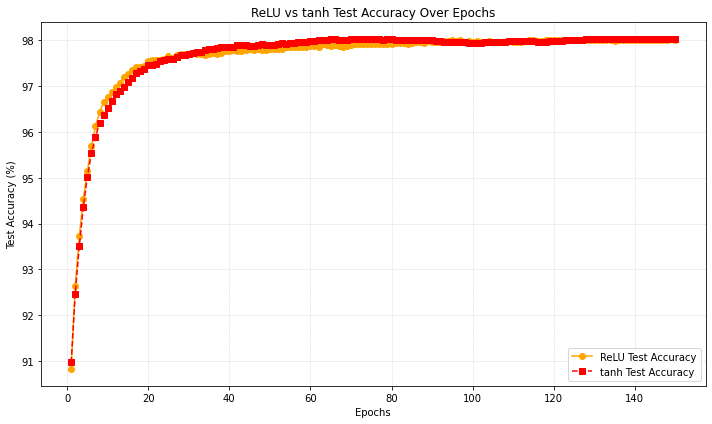

In [7]:
import torch
import matplotlib.pyplot as plt

# Activation functions
def relu(Z):
    return torch.maximum(Z, torch.tensor(0.0))

def tanh(Z):
    return torch.tanh(Z)

# Softmax function
def softmax(Z):
    expZ = torch.exp(Z - torch.max(Z, dim=0, keepdim=True).values)
    return expZ / expZ.sum(dim=0, keepdim=True)

# Forward pass with specified activation function
def forward_activation(X, W1, b1, W2, b2, activation):
    Z1 = W1 @ X + b1
    A1 = activation(Z1)
    Z2 = W2 @ A1 + b2
    A2 = softmax(Z2)
    return Z1, A1, Z2, A2

# Training the model with different activation functions
def train_model(X_train, Y_train, X_test, Y_test, input_dim, hidden_dim, output_dim, epochs, batch_size, lr, activation_func):
    W1 = torch.randn(hidden_dim, input_dim) * 0.01
    b1 = torch.zeros(hidden_dim, 1)
    W2 = torch.randn(output_dim, hidden_dim) * 0.01
    b2 = torch.zeros(output_dim, 1)
    test_accuracies = []

    for epoch in range(epochs):
        num_batches = X_train.shape[1] // batch_size

        for batch in range(num_batches):
            X_batch = X_train[:, batch * batch_size: (batch + 1) * batch_size]
            Y_batch = Y_train[:, batch * batch_size: (batch + 1) * batch_size]

            # Forward pass with chosen activation function
            Z1, A1, Z2, A2 = forward_activation(X_batch, W1, b1, W2, b2, activation_func)
            loss = -torch.mean(torch.log(A2[Y_batch.argmax(0), torch.arange(batch_size)]))

            # Backpropagation
            dZ2 = A2 - Y_batch
            dW2 = dZ2 @ A1.T / batch_size
            db2 = dZ2.sum(dim=1, keepdim=True) / batch_size
            dA1 = W2.T @ dZ2

            # Activation function derivative handling
            if activation_func == relu:
                dZ1 = dA1 * (Z1 > 0)
            elif activation_func == tanh:
                dZ1 = dA1 * (1 - torch.tanh(Z1)**2)

            dW1 = dZ1 @ X_batch.T / batch_size
            db1 = dZ1.sum(dim=1, keepdim=True) / batch_size

            # Updating model parameters
            W1 -= lr * dW1
            b1 -= lr * db1
            W2 -= lr * dW2
            b2 -= lr * db2

        # Calculating test accuracy after each epoch
        _, _, _, A2_test = forward_activation(X_test, W1, b1, W2, b2, activation_func)
        test_accuracy = (A2_test.argmax(0) == Y_test.argmax(0)).float().mean().item()
        test_accuracies.append(test_accuracy * 100)

        if (epoch + 1) % 25 == 0:
            print(f"Epoch {epoch + 1}: Test Accuracy = {test_accuracy * 100:.2f}%")

    return test_accuracies

# Experimenting with ReLU and tanh activation functions
def compare_activation_functions():
    # Loading the MNIST dataset
    X_train, Y_train, X_test, Y_test = load_mnist_data()

    # One-hot encode labels
    Y_train = one_hot_encode(Y_train, 10)
    Y_test = one_hot_encode(Y_test, 10)

    # Defining common hyperparameters
    input_dim = 784
    hidden_dim = 100
    output_dim = 10
    epochs = 150
    lr = 0.01
    batch_size = 10

    # Training using ReLU activation function
    print("Training with ReLU activation")
    relu_accuracies = train_model(X_train, Y_train, X_test, Y_test, input_dim, hidden_dim, output_dim, epochs, batch_size, lr, relu)

    # Training using tanh activation function
    print("Training with tanh activation")
    tanh_accuracies = train_model(X_train, Y_train, X_test, Y_test, input_dim, hidden_dim, output_dim, epochs, batch_size, lr, tanh)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    epochs_range = range(1, epochs + 1)
    
    # Plotting ReLU results
    plt.plot(epochs_range, relu_accuracies, label='ReLU Test Accuracy', marker='o', linestyle='-', color='orange')
    
    # Plotting tanh results
    plt.plot(epochs_range, tanh_accuracies, label='tanh Test Accuracy', marker='s', linestyle='--', color='red')

    plt.title('ReLU vs tanh Test Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy (%)')
    plt.legend()
    plt.grid(visible=True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

# Running the activation comparison experiment
compare_activation_functions()
